In [1]:
import os
import warnings
from glob import glob
from typing import List, Tuple

import IPython.display as ipd
import librosa
import librosa.display
import librosa.filters
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.fft
import sklearn
import soundfile as sf
import torch
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from torchaudio.transforms import AmplitudeToDB, MelSpectrogram
from torchvision.transforms import Compose

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
def load_yn_dataset(directory):
    X, labels = [], []
    bad_files = set(["0_1_0_1_0_0_0_0"])
    for f in glob(directory +"/*.wav"):
        name = os.path.basename(f)[:-4]
        if name in bad_files:
            continue
        y = [int(l) for l in name.split("_")]
        x, _ = librosa.load(f)
        X.append(x)
        labels.append(y)
        
    return X, labels
        
X, Y = load_yn_dataset("waves_yesno/")

In [3]:
def VAD(wav: np.ndarray, sr: int, step: int = 10, hop_length = 512, threshold: int = -3.0) -> List[np.ndarray]:
    window = scipy.signal.get_window("hann", step)
    mfcc = librosa.feature.mfcc(wav, sr, n_mfcc=20, n_mels=128, hop_length=hop_length)
    if mfcc.shape[1] % step != 0:
        pad_lenght = ((mfcc.shape[1] // step) + 1) * step - mfcc.shape[1]
        mfcc = np.pad(mfcc, (0, pad_lenght), "reflect")

    y_wav = np.zeros(mfcc.shape[1] * hop_length)
    for i in range(0, mfcc.shape[1], step):
        frame = mfcc[:, i: i+step] * window
        # frame = frame[10:,:]
        aver_power_low = frame[10:,:].sum() / np.dot(*frame[10:,:].shape)
        # aver_power_hight = frame[:10,:].sum() / np.dot(*frame[:10,:].shape)
        
        if aver_power_low < threshold:
            y_wav[i*hop_length:(i+step)*hop_length] = 1
        else:
            y_wav[i*hop_length:(i+step)*hop_length] = 0
    
    return y_wav[0:wav.shape[0]]

In [4]:
def reconstruct_data(wavs: List[np.ndarray], labels: List[int]) -> Tuple[List[np.ndarray], List[int]]:
    voices_labels = [VAD(x, 8000, step=9, hop_length=256, threshold=-2.2) for x in wavs]
    
    split_indices = list()
    new_labels = list()
    for i in range(len(wavs)):
        voice_labels = voices_labels[i]
        word_labels = labels[i]
        
        split_index = list()
        new_label = list()
        
        word_idx = 0
        prev_label = voice_labels[0]
        if voice_labels[0] == 0:
            new_label.append(2)
        else:
            new_label.append(word_labels[word_idx])
            word_idx += 1

        for idx, label in enumerate(voice_labels):
            if label != prev_label:
                split_index.append(idx)
                if label == 0:
                    new_label.append(2)
                else:
                    if word_idx < len(word_labels):
                        new_label.append(word_labels[word_idx])
                        word_idx += 1
                    else:
                        new_label.append(2)
            prev_label = label
        
        split_indices.append(split_index)
        new_labels.append(new_label)

    
    new_X = list()
    new_Y = list()
    for idx, split_index in enumerate(split_indices):
        label = new_labels[idx]
        short_wavs = np.split(wavs[idx], np.array(split_index))

        new_X.extend(short_wavs)
        new_Y.extend(label)

    return new_X, new_Y

In [5]:
new_X, new_Y = reconstruct_data(X, Y)
X_train, X_test, Y_train, Y_test = train_test_split(new_X, new_Y,test_size=0.2, random_state=1)

In [6]:
transform = Compose([
    MelSpectrogram(sample_rate=8000, n_mels=128, n_fft=4096, win_length=4096, hop_length=2048, pad_mode="reflect", f_max=1500),
    AmplitudeToDB(stype="power", top_db=80)
])

In [7]:
X_train.index(max(X_train, key=len))

230

2


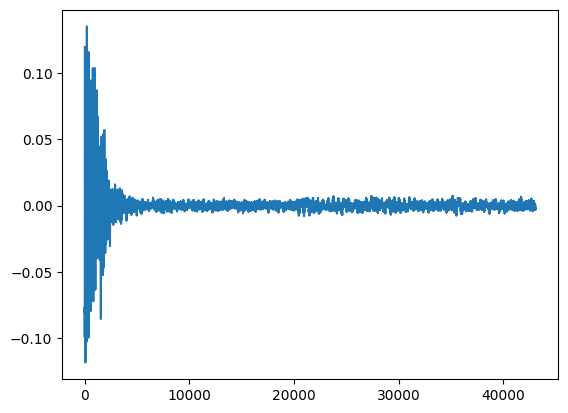

In [8]:
idx = 230
print(Y_train[idx])
plt.plot(X_train[idx])
plt.show()

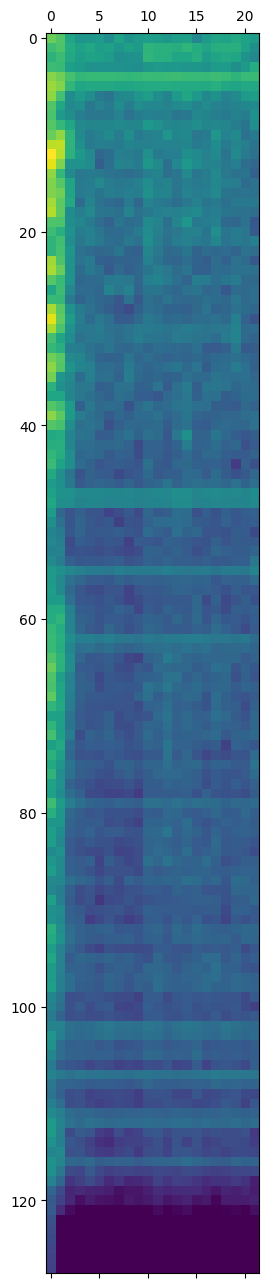

In [9]:
plt.matshow(transform(torch.from_numpy(X_train[idx])))
plt.show()

In [10]:
pd.Series([round(len(wav), -3) for wav in X_train]).value_counts().head()

5000     295
7000     203
9000     126
2000      61
12000     22
dtype: int64

In [11]:
def crop_waveforms(waveforms: List[np.ndarray], length: int = 7000) -> torch.Tensor:
    processed_X_tarin = list()
    for waveform in waveforms:
        if waveform.shape[0] >= length:
            start = (waveform.shape[0] - length) // 2
            end = waveform.shape[0] - start
            if (waveform.shape[0] - length) % 2:
                end -= 1
            waveform = torch.from_numpy(waveform[start:end])
        else:
            count = (length - waveform.shape[0]) // 2
            if (length - waveform.shape[0]) % 2 == 1:    
                padding = (count, count + 1)
            else:
                padding = (count, count)
            waveform = torch.from_numpy(np.pad(waveform, padding, mode="constant"))
        
        waveform = waveform.unsqueeze(0)
        processed_X_tarin.append(waveform)
    processed_X_tarin = torch.cat(processed_X_tarin)
    return processed_X_tarin

In [12]:
model = DecisionTreeClassifier(random_state=1).fit(transform(crop_waveforms(X_train)).reshape(len(Y_train), -1), Y_train)

In [13]:
Y_pred = model.predict(transform(crop_waveforms(X_test)).reshape(len(Y_test), -1))

In [14]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87        40
           1       0.88      0.96      0.92        48
           2       1.00      0.98      0.99       113

    accuracy                           0.95       201
   macro avg       0.93      0.93      0.93       201
weighted avg       0.95      0.95      0.95       201

